In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('fulldata.csv')
test_df=pd.read_csv('test.csv')

In [3]:
X = data.drop(['SeriousDlqin2yrs', 'ID'],axis=1)
y = data['SeriousDlqin2yrs']
W = test_df.drop(['SeriousDlqin2yrs', 'ID'],axis=1)
z = test_df['SeriousDlqin2yrs']

In [4]:
# 用线性回归模型
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=111)

# 调用线性回归函数，C为正则化系数，l1表示L1正则化
logit = LogisticRegression(random_state=111, solver='saga', penalty='l1', class_weight='balanced', C=1.0, max_iter=500)

# 标准化拟合
scaler = StandardScaler().fit(X_train)

# 标准化X_train 和X_test
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 线性回归拟合
logit.fit(X_train_scaled, y_train)

# 输入训练集，返回每个样本对应到每种分类结果的概率
logit_scores_proba = logit.predict_proba(X_train_scaled)

# 返回分类1的概率
logit_scores = logit_scores_proba[:,1]

In [5]:
# 画图
def plot_roc_curve(fpr, tpr, label=None):
    plt.figure(figsize=(12,10))
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1], "k--") # 画直线做参考
    plt.axis([0,1,0,1])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive rate")

AUC Score :  0.8389330585826046


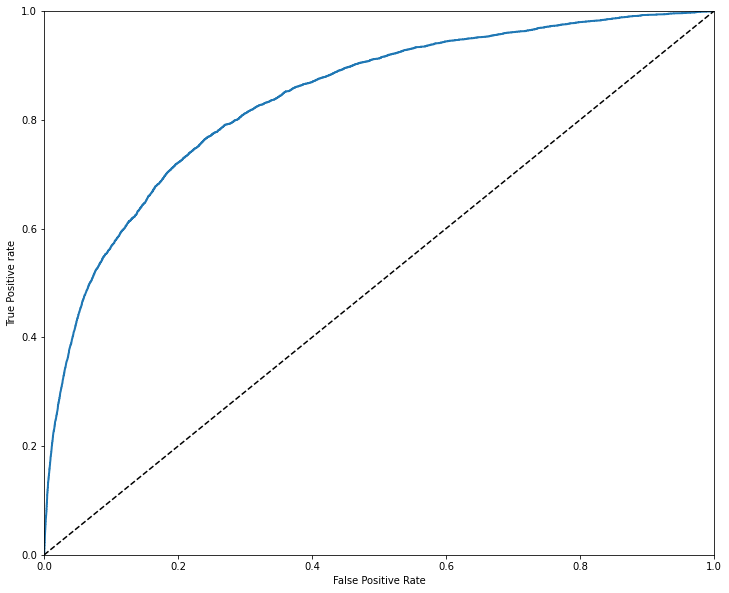

In [6]:
# roc_curve根据分类结果和分类概率，返回false positive rage和true positive rate
fpr_logit, tpr_logit, thresh_logit = roc_curve(y_train, logit_scores)

# 画图
plot_roc_curve(fpr_logit,tpr_logit)
print ('AUC Score : ', (roc_auc_score(y_train,logit_scores)))

AUC Score : 0.8374873120543433


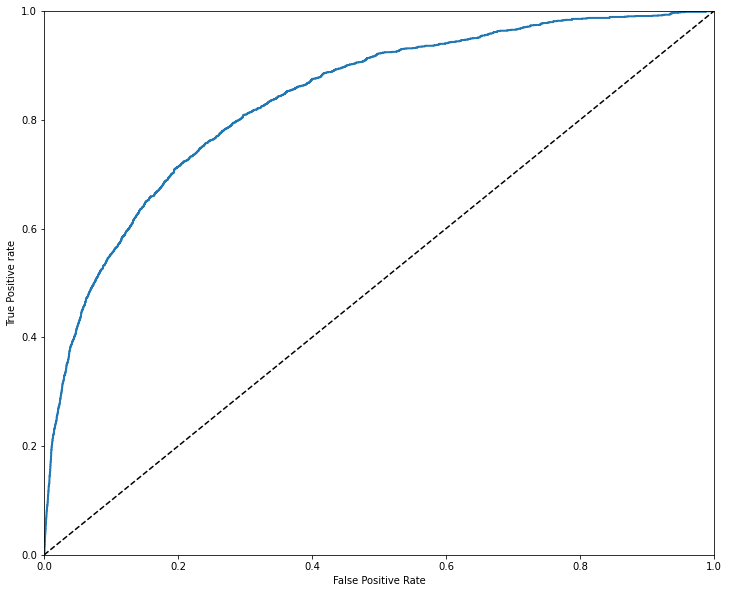

In [7]:
# 验证测试集，测试分类结果概率分布
logit_scores_proba_val = logit.predict_proba(X_test_scaled)

# 分类结果为1的概率
logit_scores_val = logit_scores_proba_val[:,1]

# roc_curve根据分类结果和分类概率，返回false positive rage和true positive rate
fpr_logit_val, tpr_logit_val, thresh_logit_val = roc_curve(y_test, logit_scores_val)

# 画图
plot_roc_curve(fpr_logit_val,tpr_logit_val)
print ('AUC Score :', (roc_auc_score(y_test,logit_scores_val)))

In [8]:
# 采用LogisticRegressionCV来交叉验证选择正则化系数C
from sklearn.linear_model import LogisticRegressionCV
logit = LogisticRegressionCV(Cs=[0.001, 0.01, 0.1, 1, 10, 100], penalty='l1', solver='saga', max_iter=500, class_weight='balanced', random_state=111)

# 线性回归拟合
logit.fit(X_train_scaled, y_train)

print (logit.C_)

[10.]


AUC Score :  0.8389325809644818


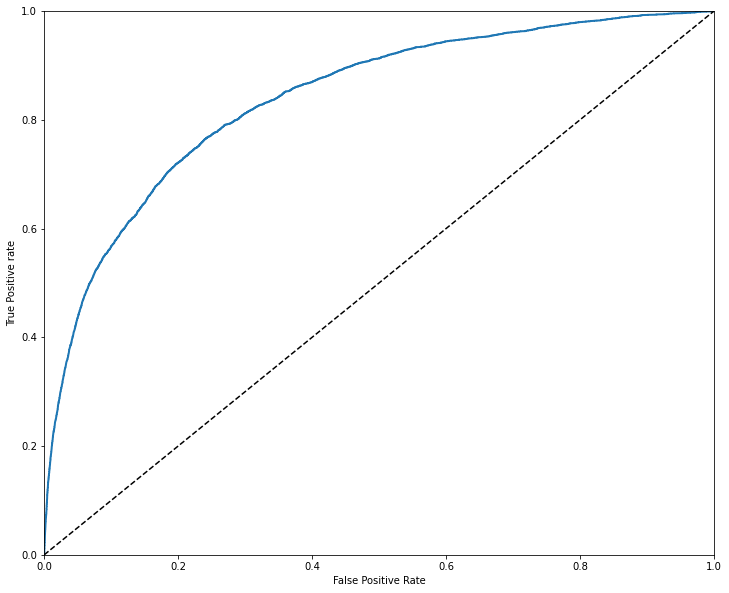

In [9]:
# 输入训练集，返回每个样本对应到每种分类结果的概率
logit_scores_proba = logit.predict_proba(X_train_scaled)

# 返回分类1的概率
logit_scores = logit_scores_proba[:,1]

# roc_curve根据分类结果和分类概率，返回false positive rage和true positive rate
fpr_logit, tpr_logit, thresh_logit = roc_curve(y_train, logit_scores)

# 画图
plot_roc_curve(fpr_logit,tpr_logit)
print ('AUC Score : ', (roc_auc_score(y_train,logit_scores)))

In [10]:
# 引入降采样模块
from imblearn.under_sampling import RandomUnderSampler

# Counter类的目的是用来跟踪值出现的次数
from collections import Counter
print ('Original dataset shape :', Counter(y))

Original dataset shape : Counter({0: 104619, 1: 6632})


In [11]:
# 调用模块
rus = RandomUnderSampler(random_state=111)

# 直接降采样后返回采样后的数值
X_resampled, y_resampled = rus.fit_resample(X, y)
print ('Resampled dataset shape:', Counter(y_resampled))

Resampled dataset shape: Counter({0: 6632, 1: 6632})


In [12]:
# 划分训练集和测试集
from sklearn.model_selection import train_test_split
X_train_rus, X_test_rus, y_train_rus, y_test_rus = train_test_split(X_resampled, y_resampled, random_state=111)
X_train_rus.shape, y_train_rus.shape

((9948, 10), (9948,))

D:\anaconda\envs\tensorflow\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
AUC score:  0.6025954232212571


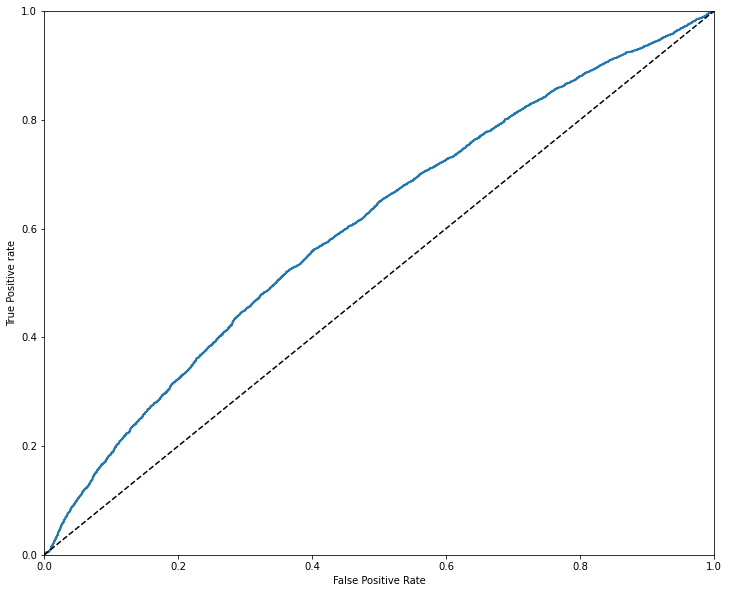

In [13]:
# 对重采样以后的数据进行分类
logit_resampled = LogisticRegression(random_state=111, solver='saga', penalty='l1', class_weight='balanced', C=1.0, max_iter=500)

logit_resampled.fit(X_resampled, y_resampled)
logit_resampled_proba_res = logit_resampled.predict_proba(X_resampled)
logit_resampled_scores = logit_resampled_proba_res[:, 1]
fpr_logit_resampled, tpr_logit_resampled, thresh_logit_resampled = roc_curve(y_resampled, logit_resampled_scores)
plot_roc_curve(fpr_logit_resampled, tpr_logit_resampled)
print ('AUC score: ', roc_auc_score(y_resampled, logit_resampled_scores))

AUC score: 0.8493964883212697


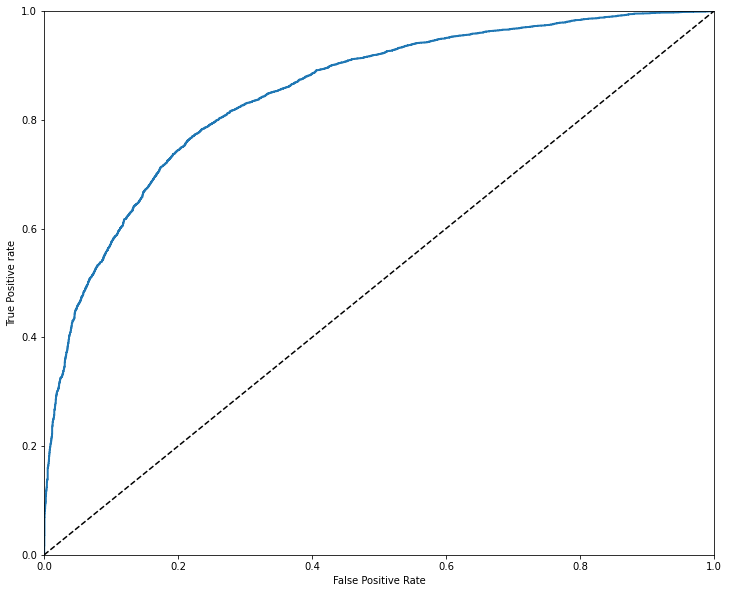

In [14]:
# 采用随机森林法分类和梯度上升法
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
forest = RandomForestClassifier(n_estimators=300, random_state=111, max_depth=5, class_weight='balanced')
forest.fit(X_train_rus, y_train_rus)
y_scores_prob = forest.predict_proba(X_train_rus)
y_scores = y_scores_prob[:, 1]
fpr, tpr, thresh = roc_curve(y_train_rus, y_scores)
plot_roc_curve(fpr, tpr)
print ('AUC score:', roc_auc_score(y_train_rus, y_scores))

AUC Score: 0.8308677905428511


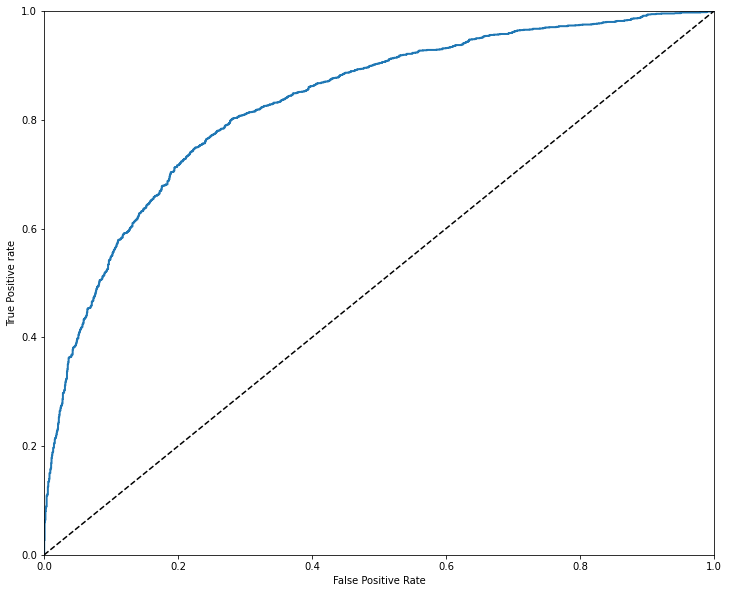

In [15]:
# 交叉验证
y_test_proba = forest.predict_proba(X_test_rus)
y_scores_test = y_test_proba[:, 1]
fpr_test, tpr_test, thresh_test = roc_curve(y_test_rus, y_scores_test)
plot_roc_curve(fpr_test, tpr_test)
print ('AUC Score:', roc_auc_score(y_test_rus, y_scores_test))

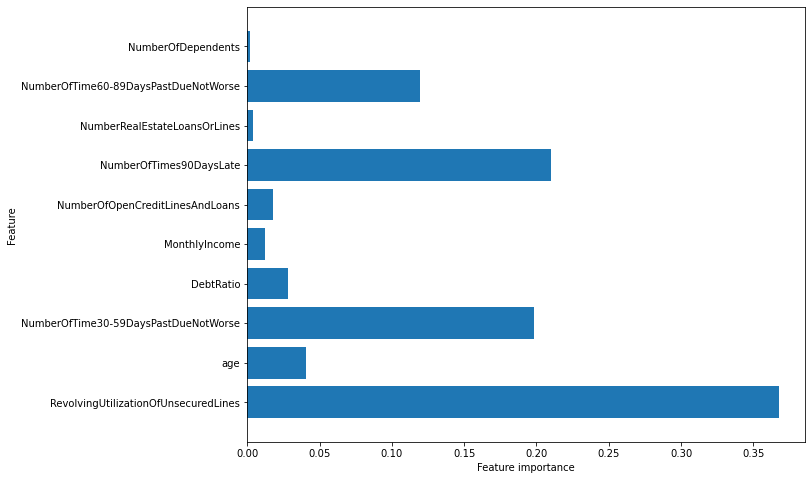

In [16]:
# 看看随机森林法对各个特征的重视程度
def plot_feature_importances(model):
    plt.figure(figsize=(10,8))
    n_features = X.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), X.columns)
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')
    plt.ylim(-1, n_features)

plot_feature_importances(forest)

AUC Score : 0.8752353627642284
AUC Score : 0.8353695403846013


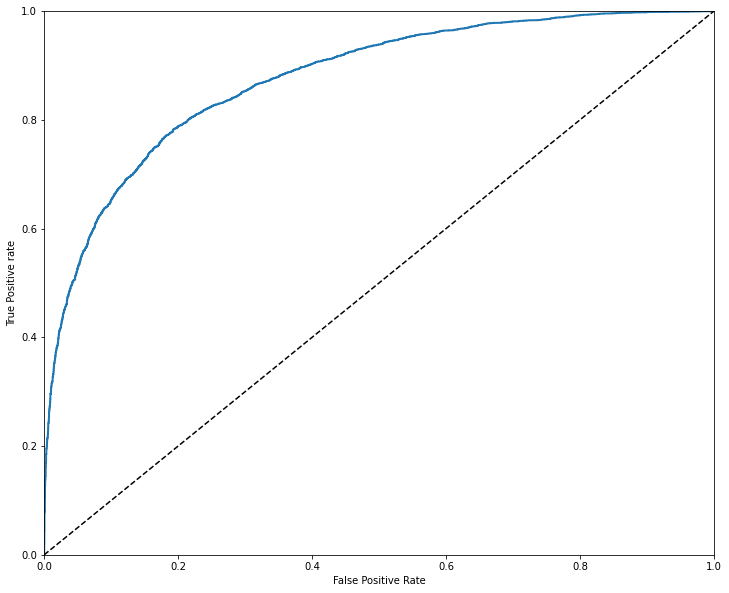

In [17]:
gbc_clf_submission = GradientBoostingClassifier(n_estimators=200, learning_rate=0.05 ,max_depth=4,  random_state=42)
gbc_clf_submission.fit(X_train_rus,y_train_rus)
gbc_clf_proba = gbc_clf_submission.predict_proba(X_train_rus)
gbc_clf_scores = gbc_clf_proba[:,1]
gbc_val_proba = gbc_clf_submission.predict_proba(X_test_rus)
gbc_val_scores = gbc_val_proba[:,1]
fpr_gbc, tpr_gbc, thresh_gbc = roc_curve(y_train_rus, gbc_clf_scores)
print ('AUC Score :', roc_auc_score(y_train_rus, gbc_clf_scores))
print ('AUC Score :', roc_auc_score(y_test_rus, gbc_val_scores))
plot_roc_curve(fpr_gbc, tpr_gbc)


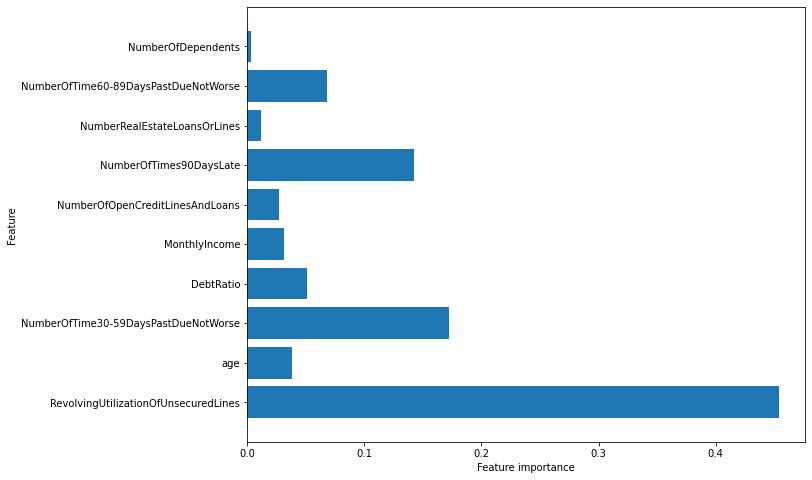

In [18]:
plot_feature_importances(gbc_clf_submission)

In [19]:
submission_proba = gbc_clf_submission.predict_proba(W)
submission_scores = submission_proba[:, 1]

In [20]:
submission = pd.DataFrame( {'Probability': submission_scores})
submission.to_csv('submission_temp.csv', index=False)